In [161]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pbn import operations as ops
from pbn import conversions as convert
from pbn import functions as fxn
from scipy import ndimage
%matplotlib inline

In [162]:
def get_na_counts(df):
    return df.apply(pd.Series.isnull).apply(pd.Series.value_counts)

(900, 723, 3)


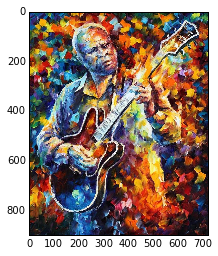

In [287]:
import matplotlib.image as matimg
#img_d = matimg.imread('/Users/eczech/Downloads/google.png')
img_rgb = matimg.imread('/Users/eczech/Downloads/afrimov_bbking.png')
print(img_rgb.shape)
plt.imshow(img_rgb)

In [288]:
img_rgb = img_rgb[:200,:400,:]

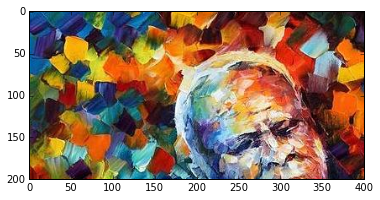

In [289]:
plt.imshow(img_rgb)

In [290]:
img_lab = convert.rgb_to_lab(img_rgb)

In [291]:
def unravel(d, color_cols=['l', 'a', 'b']):
    n2d = d.shape[0] * d.shape[1]
    colors = np.empty((n2d, 5))
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            z = i * d.shape[1] + j
            colors[z] = [float(i), float(j)] + list(d[i, j, :])
    return pd.DataFrame(colors, columns=['x', 'y'] + color_cols)

In [292]:
#alpha = .002 # best so far for gmm
alpha = .004 # also good for gmm
#alpha = 10
img_df = unravel(img_lab)
img_df[['l', 'a', 'b']] = img_df[['l', 'a', 'b']] * alpha
img_df.head()

,x,y,l,a,b
0,0,0,0.138338,0.017247,-0.164449
1,0,1,0.246500,-0.027042,-0.161878
2,0,2,0.181279,-0.009071,-0.160252
3,0,3,0.181279,-0.009071,-0.160252
4,0,4,0.161637,-0.001464,-0.158474


In [293]:
from sklearn.mixture import DPGMM, GMM
#mm = DPGMM(n_components=1000, alpha=.1, n_iter=50)
mm = GMM(n_components=150)
#mm = GMM(n_components=500)
mm.fit(img_df)
img_pred = mm.predict(img_df)

In [294]:
mm.converged_

True

In [295]:
len(np.unique(img_pred))

150

In [296]:
mm.means_.shape

(150, 5)

In [297]:
img_all = pd.concat([img_df, pd.Series(img_pred)], axis=1)
img_all = img_all.rename(columns={0: 'c'})
img_all.index.name = 'order'
img_all.head()

,x,y,l,a,b,c
order,,,,,,
0,0,0,0.138338,0.017247,-0.164449,118
1,0,1,0.246500,-0.027042,-0.161878,118
2,0,2,0.181279,-0.009071,-0.160252,118
3,0,3,0.181279,-0.009071,-0.160252,118
4,0,4,0.161637,-0.001464,-0.158474,118


In [298]:
len(img_all['c'].unique())

150

In [299]:
color_clusters = img_all.groupby('c')[['l', 'a', 'b']].mean()
color_clusters.head()

,l,a,b
c,,,
0,0.155456,-0.034241,0.130095
1,0.337016,0.018581,0.085435
2,0.311030,0.023968,0.048760
3,0.142992,-0.013346,0.091158
4,0.112455,0.107607,0.130349


In [300]:
n_before = len(img_all)
img_merged = img_all.reset_index()\
    .merge(color_clusters.reset_index(), on='c', suffixes=['', '_m'])\
    .sort('order').set_index('order')
assert n_before == len(img_merged),\
    'Some rows were somehow lost during join: size before = {}, size after = {}'.format(n_before, len(img_merged))
assert np.all(img_merged.apply(np.isfinite).apply(np.all)), 'Merged data frame has NA values somehow'
img_merged.iloc[1000:1010]

,x,y,l,a,b,c,l_m,a_m,b_m
order,,,,,,,,,
1000,2,200,0.258833,0.080783,0.272345,5,0.280142,0.047211,0.277424
1001,2,201,0.223813,0.100218,0.251988,55,0.222269,0.132244,0.226172
1002,2,202,0.199494,0.119085,0.233201,55,0.222269,0.132244,0.226172
1003,2,203,0.202434,0.127477,0.236477,55,0.222269,0.132244,0.226172
1004,2,204,0.203975,0.136191,0.238621,55,0.222269,0.132244,0.226172
1005,2,205,0.196389,0.145771,0.233209,55,0.222269,0.132244,0.226172
1006,2,206,0.205377,0.148421,0.241016,55,0.222269,0.132244,0.226172
1007,2,207,0.226911,0.151483,0.246953,55,0.222269,0.132244,0.226172
1008,2,208,0.220039,0.161988,0.249122,55,0.222269,0.132244,0.226172


In [301]:
import imp
imp.reload(convert)
imp.reload(ops)
imp.reload(fxn)

<module 'pbn.functions' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/functions.py'>

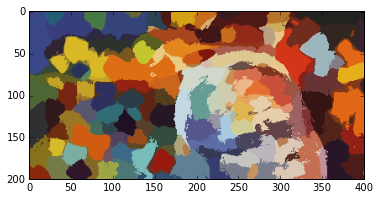

In [328]:
img_color = img_merged[[c for c in img_merged.columns if c.endswith('_m')]]
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = fxn.denoise_raw_img(img_color, 1)
plt.imshow(img_color)
plt.imsave('/tmp/pbn_prelim.png', img_color)

## Collapse Colors

In [329]:
avg_color_cols = [c for c in img_merged.columns if c.endswith('_m')]

In [138]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

def collapse_colors(flt_cluster, color_cols, n_colors=10, alpha=1):
    X = flt_cluster[color_cols] / alpha
    mm = GMM(n_components=n_colors)
    y = pd.Series(mm.fit(X).predict(X))
    assert mm.converged_, 'Mixture model did not converge'
    mean_map = dict([ (i, v * alpha) for i, v in enumerate(mm.means_) ])
    flt_cluster[['{}_c'.format(c) for c in color_cols]] = y.map(mean_map).apply(pd.Series)
    flt_cluster['cc'] = y
    return flt_cluster.sort_index(), mm


## Normalize Colors to Clusters

In [402]:
img_clustered, cmm = collapse_colors(img_merged, avg_color_cols, n_colors=25, alpha=alpha)
clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_c')]
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_p,a_m_p,b_m_p,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,,,,
0,0,0,0.138338,0.017247,-0.164449,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
1,0,1,0.246500,-0.027042,-0.161878,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
2,0,2,0.181279,-0.009071,-0.160252,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
3,0,3,0.181279,-0.009071,-0.160252,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
4,0,4,0.161637,-0.001464,-0.158474,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12


In [401]:
# imp.reload(palettes)

# from pbn import palettes
# palette = pd.DataFrame(palettes.rainbow_all)
# palette = palette.apply(convert._rgb_to_lab, axis=1).apply(pd.Series)
# palette *= alpha
# img_matched = fxn.match_to_palette(img_merged[avg_color_cols], palette)
# img_matched.head()

# img_clustered = img_merged.copy()
# img_clustered[['l_m_p', 'a_m_p', 'b_m_p']] = img_matched
# clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_p')]
# img_clustered.head()

# # Show number actually matched
# img_clustered[clustered_color_cols].drop_duplicates()

### Denoise Result

In [409]:
#img_denoised = fxn.denoise_flat_img(img_clustered, img_rgb.shape, ['l_m_c', 'a_m_c', 'b_m_c'], n_iter=3)
#denoise_color_cols = [c for c in img_denoised.columns if c.endswith('_dn')]
#print(denoise_color_cols)
#img_denoised.head()

Index(['l_m_c', 'a_m_c', 'b_m_c'], dtype='object')


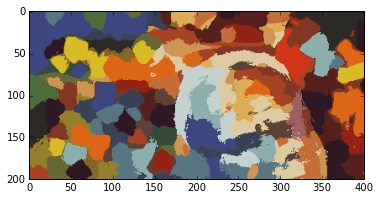

In [408]:
img_color = img_clustered[clustered_color_cols]
print(img_color.columns)
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = denoise_raw_img(img_color, 1)
plt.imsave('/tmp/pbn_collapsed.png', img_color)
plt.imshow(img_color)

## Show Cluster Membership

In [381]:
def get_cluster_img(flt_cluster, img_d):
    """ expecting [ c, x, y, l, a, b ] where c is cluster and l, a, and b are color means """
    colors = {}
    res = np.empty_like(img_d)
    for cluster in flt_cluster['c'].unique():
        colors[cluster] = [np.random.rand(), np.random.rand(), np.random.rand()]
    for i, r in flt_cluster[['x', 'y', 'c']].iterrows():
        res[r['x'], r['y']] = colors[r['c']]
    return res

In [382]:
img_clusters = get_cluster_img(img_clustered, img_rgb)

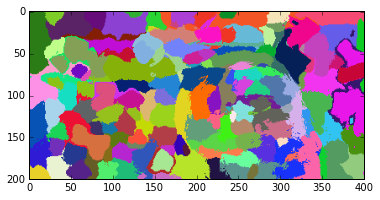

In [383]:
plt.imshow(img_clusters)

# Results

In [410]:
color_matrix = ops.reravel(img_clustered[['cc']], *img_rgb.shape[:2])
color_matrix = np.int64(np.reshape(color_matrix, img_rgb.shape[0:2]))
color_matrix.shape

(200, 400)

In [411]:
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_p,a_m_p,b_m_p,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,,,,
0,0,0,0.138338,0.017247,-0.164449,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
1,0,1,0.246500,-0.027042,-0.161878,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
2,0,2,0.181279,-0.009071,-0.160252,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
3,0,3,0.181279,-0.009071,-0.160252,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12
4,0,4,0.161637,-0.001464,-0.158474,118,0.126349,0.039939,-0.152422,0.224741,-0.024951,-0.178529,0.126034,0.037771,-0.13561,12


In [412]:
# Run this to make sure that the color clusters really only have one color per cluster
img_clustered.groupby('cc').apply(lambda x: len(x[['l_m_c', 'a_m_c', 'b_m_c']].drop_duplicates())).value_counts()
# This should report only "1" with a count equal to the number of clusters

1    25
dtype: int64

In [413]:
collapsed_color_clusters = img_clustered.groupby('cc')\
    .apply(lambda x: x[['l_m_c', 'a_m_c', 'b_m_c']].iloc[0])
collapsed_color_clusters.head()

,l_m_c,a_m_c,b_m_c
cc,,,
0,0.331542,-0.019877,0.001776
1,0.134897,0.123704,0.113130
2,0.110856,0.007275,-0.057170
3,0.231408,0.176999,0.246687
4,0.172372,-0.079596,0.096318


In [414]:
spatial_clusters = ops.cluster_by_proximity(color_matrix, threshold=.8, shrinkage=1, n_iterations=1)

141 clusters collapsed of 373


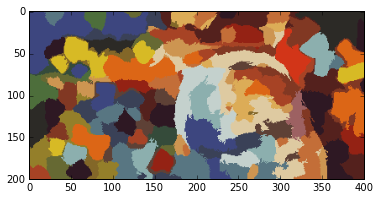

In [416]:
img_reassembled = ops.image_from_clusters(spatial_clusters, collapsed_color_clusters, img_rgb, use_random_color=False)
img_reassembled = convert.lab_to_rgb(img_reassembled / alpha)
plt.imsave('/tmp/pbn_rand.png', img_reassembled)
plt.imshow(img_reassembled)

In [718]:
img_reassembled.shape

(200, 400, 3)

In [419]:
cluster_props = ops.get_cluster_props(spatial_clusters, collapsed_color_clusters, color_matrix)

In [434]:
imp.reload(ops)

<module 'pbn.operations' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/operations.py'>

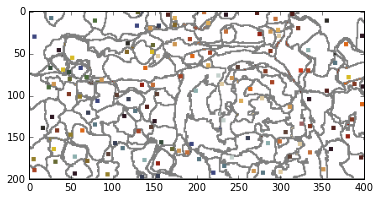

In [435]:
bkg = np.array(convert._rgb_to_lab([1, 1, 1.])) * alpha
edg = np.array(convert._rgb_to_lab([.5, .5, .5])) * alpha
img_pbn = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, size_limit=10, solution=False)
img_pbn = convert.lab_to_rgb(img_pbn / alpha)
matimg.imsave('/tmp/pbn_test_sol.png', img_pbn)
plt.imshow(img_pbn)

## Color Palette

In [242]:
imp.reload(fxn)

<module 'pbn.functions' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/functions.py'>

##Zooming

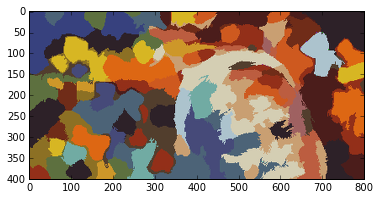

In [723]:
plt.imshow(scipy.ndimage.zoom(img_reassembled, (2, 2, 1)))

## D

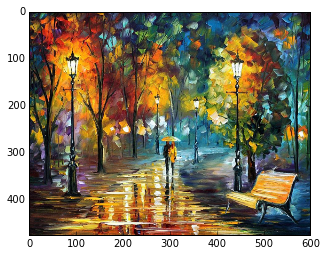

In [157]:
plt.imshow(img_d)

In [94]:
img_color[:1]

array([[[ 28.52951146,  41.8903634 ,  63.85973287],
        [ 28.52951146,  41.8903634 ,  63.85973287],
        [ 29.68364349,  26.02848577,  41.1074676 ],
        ..., 
        [ 19.85763937,  11.52777806,  19.85763943],
        [ 29.68364349,  26.02848577,  41.1074676 ],
        [ 38.47588722,  65.89200525,  86.06265656]]])